In [ ]:
%pip install tensorflow==2.0.0
%pip install keras==2.3.1

     |████████████████████████████████| 86.3 MB 38 kB/s 
     |████████████████████████████████| 50 kB 4.8 MB/s 
     |████████████████████████████████| 449 kB 39.6 MB/s 
     |████████████████████████████████| 3.8 MB 45.2 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=6ccc324d8c185f5b4c03bc2dfe4c76be877a16b6db70be878ad8bba84829ba02
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Success

In [ ]:
import itertools
import pandas as pd
import numpy as np
import re
import os
from tqdm import tqdm

# Drawing the embeddings
import matplotlib.pyplot as plt

# Deep learning: 
from keras.models import Input, Model
from keras.layers import Dense

from scipy import sparse

Using TensorFlow backend.


# Wrod embeding-reuters

### download dataset

In [ ]:
path_to_reuters = '/root/nltk_data/corpora/reuters'
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
!unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

Streaming output truncated to the last 5000 lines.
  inflating: /root/nltk_data/corpora/reuters/training/2231  
  inflating: /root/nltk_data/corpora/reuters/training/2232  
  inflating: /root/nltk_data/corpora/reuters/training/2234  
  inflating: /root/nltk_data/corpora/reuters/training/2236  
  inflating: /root/nltk_data/corpora/reuters/training/2237  
  inflating: /root/nltk_data/corpora/reuters/training/2238  
  inflating: /root/nltk_data/corpora/reuters/training/2239  
  inflating: /root/nltk_data/corpora/reuters/training/2240  
  inflating: /root/nltk_data/corpora/reuters/training/2244  
  inflating: /root/nltk_data/corpora/reuters/training/2246  
  inflating: /root/nltk_data/corpora/reuters/training/2247  
  inflating: /root/nltk_data/corpora/reuters/training/2249  
  inflating: /root/nltk_data/corpora/reuters/training/225  
  inflating: /root/nltk_data/corpora/reuters/training/2251  
  inflating: /root/nltk_data/corpora/reuters/training/2252  
  inflating: /root/nltk_data/corpor

In [ ]:
def get_corpus_text(categories):
    '''
    return raw text of reuters corpus
    '''
    return [" ".join(reuters.words(fid)) for fid in reuters.fileids(categories=categories)]

crude_dataset = get_corpus_text(['crude'])
print('length of the dataset realted to crude : {}'.format(len(crude_dataset)))


length of the dataset realted to crude : 578


In [ ]:
# pick top 100 data as train data
train_data = crude_dataset[:100] 
print('length of train data : {}'.format(len(train_data)))

length of train data : 100


### Utility

In [ ]:
import re
import numpy as np

def create_unique_word_dict(text:list) -> dict:
    """
    A method that creates a dictionary where the keys are unique words
    and key values are indices
    """
    # Getting all the unique words from our text and sorting them alphabetically
    words = list(set(text))
    words.sort()

    # Creating the dictionary for the unique words
    unique_word_dict = {}
    for i, word in enumerate(words):
        unique_word_dict.update({
            word: i
        })

    return unique_word_dict    

def text_preprocessing(
    text:list,
    punctuations = r'''!()-[]{};:'"\,<>./?@#$%^&*_“~''',
    stop_words=['and', 'a', 'is', 'the', 'in', 'be', 'will']
    )->list:
    """
    A method to preproces text
    """
    for x in text.lower(): 
        if x in punctuations: 
            text = text.replace(x, "")

    # Removing words that have numbers in them
    text = re.sub(r'\w*\d\w*', '', text)

    # Removing digits
    text = re.sub(r'[0-9]+', '', text)

    # Cleaning the whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Setting every word to lower
    text = text.lower()

    # Converting all our text to a list 
    text = text.split(' ')

    # Droping empty strings
    text = [x for x in text if x!='']

    # Droping stop words
    text = [x for x in text if x not in stop_words]

    return text

# Functions to find the most similar word 
def euclidean(vec1:np.array, vec2:np.array) -> float:
    """
    A function to calculate the euclidean distance between two vectors
    """
    return np.sqrt(np.sum((vec1 - vec2)**2))

def find_similar(word:str, embedding_dict:dict, top_n=10)->list:
    """
    A method to find the most similar word based on the learnt embeddings
    """
    dist_dict = {}
    word_vector = embedding_dict.get(word, [])
    if len(word_vector) > 0:
        for key, value in embedding_dict.items():
            if key!=word:
                dist = euclidean(word_vector, value)
                dist_dict.update({
                    key: dist
                })

        return sorted(dist_dict.items(), key=lambda x: x[1])[0:top_n]

### main


In [ ]:
# Defining the window for context
window = 2

# Creating a placeholder for the scanning of the word list
word_lists = []
all_text = []

for text in train_data:

    # Cleaning the text
    text = text_preprocessing(text)

    # Appending to the all text list
    all_text += text 

    # Creating a context dictionary
    for i, word in enumerate(text):
        for w in range(window):
            # Getting the context that is ahead by *window* words
            if i + 1 + w < len(text): 
                word_lists.append([word] + [text[(i + 1 + w)]])
            # Getting the context that is behind by *window* words    
            if i - w - 1 >= 0:
                word_lists.append([word] + [text[(i - w - 1)]])

word_lists

[['japan', 'to'],
 ['japan', 'revise'],
 ['to', 'revise'],
 ['to', 'japan'],
 ['to', 'long'],
 ['revise', 'long'],
 ['revise', 'to'],
 ['revise', 'term'],
 ['revise', 'japan'],
 ['long', 'term'],
 ['long', 'revise'],
 ['long', 'energy'],
 ['long', 'to'],
 ['term', 'energy'],
 ['term', 'long'],
 ['term', 'demand'],
 ['term', 'revise'],
 ['energy', 'demand'],
 ['energy', 'term'],
 ['energy', 'downwards'],
 ['energy', 'long'],
 ['demand', 'downwards'],
 ['demand', 'energy'],
 ['demand', 'ministry'],
 ['demand', 'term'],
 ['downwards', 'ministry'],
 ['downwards', 'demand'],
 ['downwards', 'of'],
 ['downwards', 'energy'],
 ['ministry', 'of'],
 ['ministry', 'downwards'],
 ['ministry', 'international'],
 ['ministry', 'demand'],
 ['of', 'international'],
 ['of', 'ministry'],
 ['of', 'trade'],
 ['of', 'downwards'],
 ['international', 'trade'],
 ['international', 'of'],
 ['international', 'industry'],
 ['international', 'ministry'],
 ['trade', 'industry'],
 ['trade', 'international'],
 ['trade',

### Prepare X and Y for neural network

In [ ]:
unique_word_dict = create_unique_word_dict(all_text)

# Defining the number of features (unique words)
n_words = len(unique_word_dict)

# Getting all the unique words 
words = list(unique_word_dict.keys())

# Creating the X and Y matrices using one hot encoding
X = []
Y = []

for i, word_list in tqdm(enumerate(word_lists)):
    # Getting the indices
    main_word_index = unique_word_dict.get(word_list[0])
    context_word_index = unique_word_dict.get(word_list[1])

    # Creating the placeholders   
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    # One hot encoding the main word
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words 
    Y_row[context_word_index] = 1

    # Appending to the main matrices
    X.append(X_row)
    Y.append(Y_row)

# Converting the matrices into a sparse format because the vast majority of the data are 0s
X = sparse.csr_matrix(X)
Y = sparse.csr_matrix(Y)

56416it [00:04, 11544.57it/s]


### create model

In [ ]:
# Defining the size of the embedding
embed_size = 2

# Defining the neural network
inp = Input(shape=(X.shape[1],))
x = Dense(units=embed_size, activation='linear')(inp)
x = Dense(units=Y.shape[1], activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
print(model.summary())


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 2728)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 5458      
_________________________________________________________________
dense_14 (Dense)             (None, 2728)              8184      
Total params: 13,642
Trainable params: 13,642
Non-trainable params: 0
_________________________________________________________________
None


### train model with X, Y

In [ ]:
# Optimizing the network weights
model.fit(x=X, y=Y, batch_size=256,epochs=10)

Epoch 1/10
56416/56416 [==============================] - 6s 110us/step - loss: 7.7909
Epoch 2/10
56416/56416 [==============================] - 6s 110us/step - loss: 7.3402
Epoch 3/10
56416/56416 [==============================] - 6s 109us/step - loss: 6.8769
Epoch 4/10
56416/56416 [==============================] - 6s 109us/step - loss: 6.6744
Epoch 5/10
56416/56416 [==============================] - 6s 110us/step - loss: 6.6290
Epoch 6/10
56416/56416 [==============================] - 6s 110us/step - loss: 6.6154
Epoch 7/10
56416/56416 [==============================] - 6s 110us/step - loss: 6.6077
Epoch 8/10
56416/56416 [==============================] - 6s 112us/step - loss: 6.6026
Epoch 9/10
56416/56416 [==============================] - 6s 111us/step - loss: 6.5988
Epoch 10/10
56416/56416 [==============================] - 8s 144us/step - loss: 6.5958


### plot embeddings

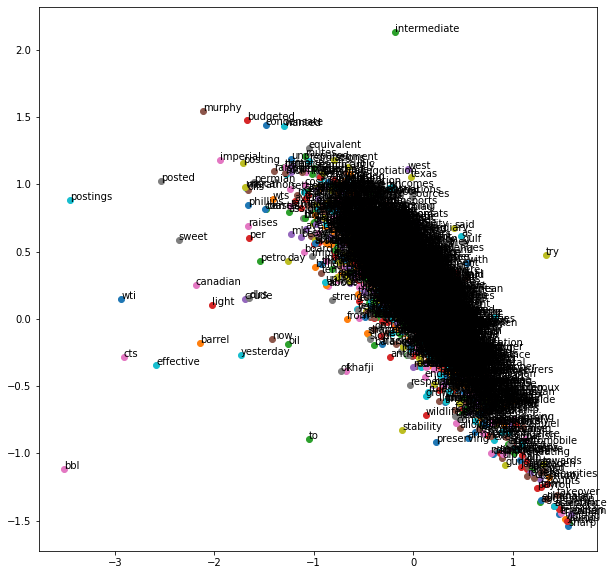

In [ ]:
# Obtaining the weights from the neural network. 
# These are the so called word embeddings

# The input layer 
weights = model.get_weights()[0]

# Creating a dictionary to store the embeddings in. The key is a unique word and 
# the value is the numeric vector
embedding_dict = {}
for word in words: 
    embedding_dict.update({
        word: weights[unique_word_dict.get(word)]
        })

# Ploting the embeddings
plt.figure(figsize=(10, 10))
for word in unique_word_dict.keys():
    coord = embedding_dict.get(word)
    if coord is None:
        continue
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))   

### plot new words

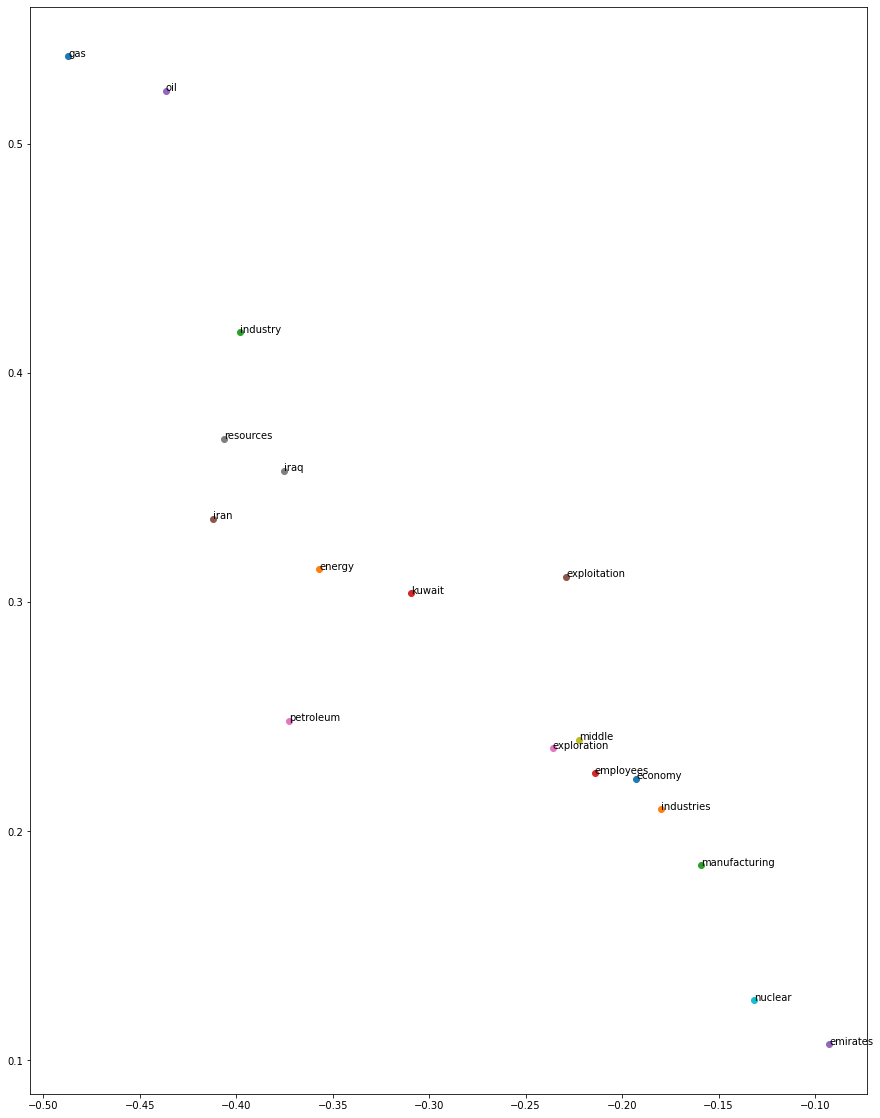

In [ ]:
# Obtaining the weights from the neural network. 
# These are the so called word embeddings

# The input layer 
weights = model.get_weights()[0]

# Creating a dictionary to store the embeddings in. The key is a unique word and 
# the value is the numeric vector
embedding_dict = {}
for word in words: 
    embedding_dict.update({
        word: weights[unique_word_dict.get(word)]
        })


new_words = [
    'gas', 'energy', 'industry', 'kuwait', 'oil', 'iran', 'petroleum', 'iraq',
'middle', 'nuclear', 'economy', 'industries', 'manufacturing', 'employees',
'emirates', 'exploitation', 'exploration', 'resources'
]
# Ploting the embeddings
plt.figure(figsize=(15, 20))
for word in new_words:
    coord = embedding_dict.get(word)
    if coord is None:
        continue
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1])) 

### find similarity to my words

In [ ]:
my_words = [
  'iran', 'iraq', 'economic', 'industry', 'build', 'gas', 'oil', 
  'energy', 'nuclear', 'employees'
]

for w in my_words:
    similarity = find_similar(w, embedding_dict=embedding_dict)
    print('similar to word {} :'.format(w))
    print()
    print([s[0] for s in similarity])
    print('='*40)
    print()

similar to word iran :

['likely', 'four', 'interest', 'start', 'possibility', 'first', 'month', 'decisions', 'small', 'southland']

similar to word iraq :

['also', 'louisiana', 'oreffice', 'colombia', 'maybe', 'fahd', 'consensus', 'adding', 'miti', 'ended']

similar to word economic :

['leblanc', 'restrictions', 'chemicals', 'bans', 'late', 'undisclosed', 'coasts', 'spending', 'fuels', 'synar']

similar to word industry :

['significantly', 'netbacks', 'quota', 'close', 'subsidiary', 'inventories', 'profits', 'military', 'higher', 'brings']

similar to word build :

['ecuador', 'wanted', 'dlr', 'pumped', 'above', 'it', 'period', 'control', 'domestic', 'budgeted']

similar to word gas :

['lichtblau', 'about', 'remain', 'gasoline', 'spokesman', 'cut', 'natural', 'eia', 'closed', 'murphy']

similar to word oil :

['capacity', 'fell', 'half', 'expect', 'closed', 'agreed', 'pacific', 'stevens', 'murphy', 'remain']

similar to word energy :

['abandoning', 'news', 'nerco', 'edmonton', 'y

# Grad-CAM - MNIST


In [ ]:
# imports
import keras
import cv2
import matplotlib.cm as cm
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers
from sklearn.utils import shuffle

### load data

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [ ]:
# shuffle
(x_train, y_train) = shuffle(x_train, y_train, random_state=42)

print('x_train shape : {}'.format(x_train.shape))
print('y_train shape : {}'.format(y_train.shape))
print('x_test shape : {}'.format(x_test.shape))
print('y_test shape : {}'.format(y_test.shape))

x_train shape : (60000, 28, 28)
y_train shape : (60000,)
x_test shape : (10000, 28, 28)
y_test shape : (10000,)


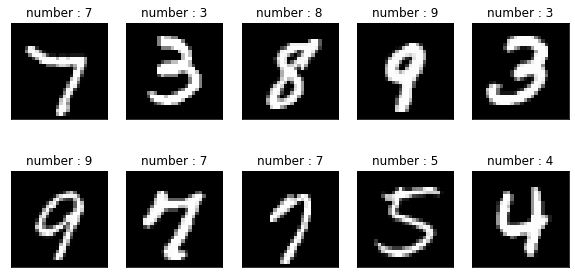

classes  : [0 1 2 3 4 5 6 7 8 9]


In [ ]:
# show data sets
row = 2
column = 5
classes = np.unique(y_train)

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(row, column, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('number : {}'.format(y_train[i]))
plt.show()

print('classes  : {}'.format(classes))

### pre-processing

In [ ]:
def pre_processing(x, y):
    x = x.astype('float32')
    y = tf.keras.utils.to_categorical(y)
    # x = (x - np.min(x)) / (np.max(x) - np.min(x))
    x = x / 255.0
    a, b, c = x.shape

    x = x.reshape((a, b, c, 1))
    
    return x, y

X_train, Y_train = pre_processing(x_train, y_train)
X_test, Y_test = pre_processing(x_test, y_test)

print('x_train shape : {}  max : {}  min : {}'.format(X_train.shape, np.max(X_train), np.min(X_train)))
print('y_train shape : {}'.format(Y_train.shape))
print('x_test shape : {}  max : {}  min : {}'.format(X_test.shape, np.max(X_test), np.min(X_test)))
print('y_test shape : {}'.format(Y_test.shape))



x_train shape : (60000, 28, 28, 1)  max : 1.0  min : 0.0
y_train shape : (60000, 10)
x_test shape : (10000, 28, 28, 1)  max : 1.0  min : 0.0
y_test shape : (10000, 10)


### Define model

In [ ]:

def make_model():
    model = Sequential()
    model.add(layers.Input(shape=X_train.shape[1:]))

    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size= (2, 2)))

    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size= (2, 2)))

    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size= (2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(len(classes), activation='softmax'))

    return model

model = make_model()

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 3, 64)        

### Train Model

In [ ]:
# compile and train model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(X_train, Y_train, batch_size=64, validation_split=0.2, epochs=15)

Epoch 1/15
750/750 [==============================] - 69s 90ms/step - loss: 0.1922 - accuracy: 0.9414 - val_loss: 0.0644 - val_accuracy: 0.9783
Epoch 2/15
750/750 [==============================] - 66s 89ms/step - loss: 0.0519 - accuracy: 0.9837 - val_loss: 0.0462 - val_accuracy: 0.9861
Epoch 3/15
750/750 [==============================] - 67s 89ms/step - loss: 0.0355 - accuracy: 0.9884 - val_loss: 0.0480 - val_accuracy: 0.9851
Epoch 4/15
750/750 [==============================] - 67s 89ms/step - loss: 0.0272 - accuracy: 0.9914 - val_loss: 0.0426 - val_accuracy: 0.9871
Epoch 5/15
750/750 [==============================] - 67s 89ms/step - loss: 0.0223 - accuracy: 0.9928 - val_loss: 0.0574 - val_accuracy: 0.9818
Epoch 6/15
750/750 [==============================] - 66s 88ms/step - loss: 0.0175 - accuracy: 0.9946 - val_loss: 0.0427 - val_accuracy: 0.9877
Epoch 7/15
750/750 [==============================] - 66s 88ms/step - loss: 0.0139 - accuracy: 0.9956 - val_loss: 0.0324 - val_accuracy:

Text(0, 0.5, 'loss')

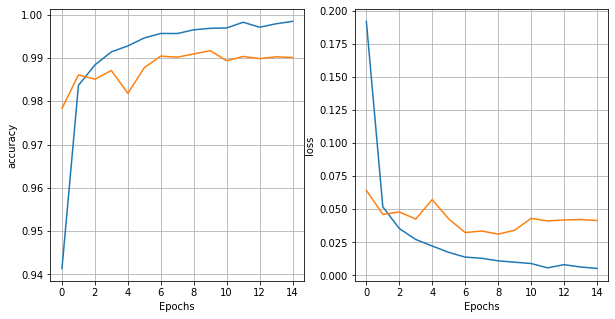

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.grid(True)
plt.ylabel('accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.grid(True)
plt.ylabel('loss')

In [ ]:
# save model
print('saving model ===>')
model.save('/content/drive/MyDrive/model.h5')


saving model ===>


### Grad-CAM


In [ ]:
# laod model
def load_model():
    model = tf.keras.models.load_model('/content/drive/MyDrive/model.h5')
    print(model.evaluate(X_test, Y_test))
    print('='*40)
    print()
    print(model.summary())
    return model

model1 = load_model()


313/313 [==============================] - 5s 15ms/step - loss: 0.0326 - accuracy: 0.9921
[0.03264323249459267, 0.9921000003814697]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)        

In [ ]:
def get_random_img():
    pics = dict()
    for digit in range(10):
        indexes = np.argwhere(y_train == digit).flatten()
        random_pic_idx = np.random.choice(indexes, 10)        
        pics[str(digit)] = random_pic_idx
    return pics


In [ ]:
last_conv_layer_name = 'conv2d_3'

def grad_cam(image, model, last_conv_layer_name = last_conv_layer_name):
    
    # we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # compute gradient of predicted class for our input image with
    # respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(image)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # gradient of the output neuron (predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)


    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # multiply each channel in the feature map array
    # with regard to the top predicted class and
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # normalize the heatmap between 0 - 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



In [ ]:
def superimpose(image, heatmap, alpha = 0.4):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img



In [ ]:
# Get random image from each class
img_dict = get_random_img()
model1.layers[-1].activation = None

# Display them
def display_number_heatmap(image_idxes):
    _id = 0
    # plot orginal 
    for i in range(10):
        plt.subplot(30, 10, i + _id * 10 + 1)
        plt.imshow(np.squeeze(X_train[image_idxes[i]], axis=2), cmap='gray')

    _id+=1
    # plot heatmap
    heatmaps = []
    for i in range(10):
          img_arr = np.expand_dims(X_train[image_idxes[i]], axis=0)
          heatmap = grad_cam(img_arr, model1)
          heatmaps.append(heatmap)
          plt.subplot(30, 10, i + _id * 10 + 1)
          plt.imshow(heatmap)
    _id+=1

    # plot heatmap on the real image
    for i in range(10):
        im_arr = np.expand_dims(x_train[image_idxes[i]], axis=2)
        res_img = superimpose(im_arr, heatmaps[i])
        plt.subplot(30, 10, i + _id * 10 + 1)
        plt.imshow(res_img)
    

#### result

for number : 0



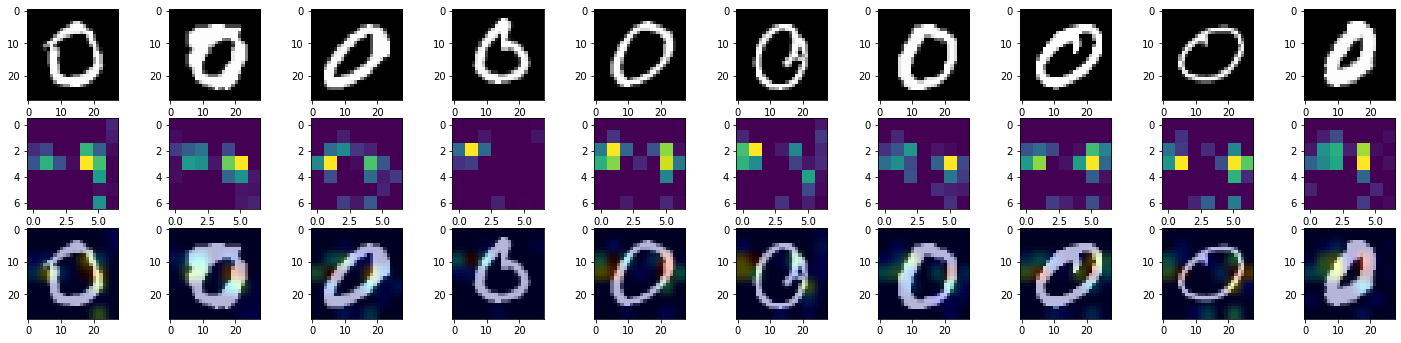


for number : 1



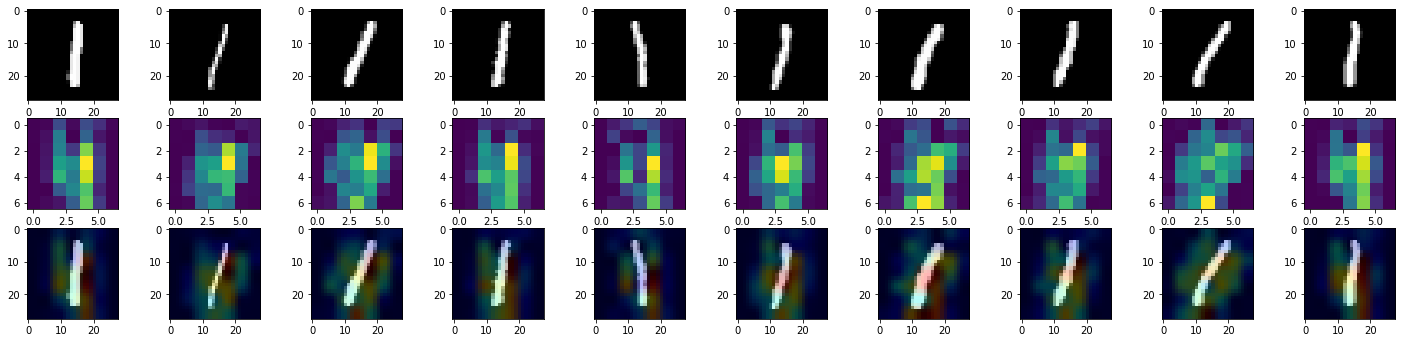


for number : 2



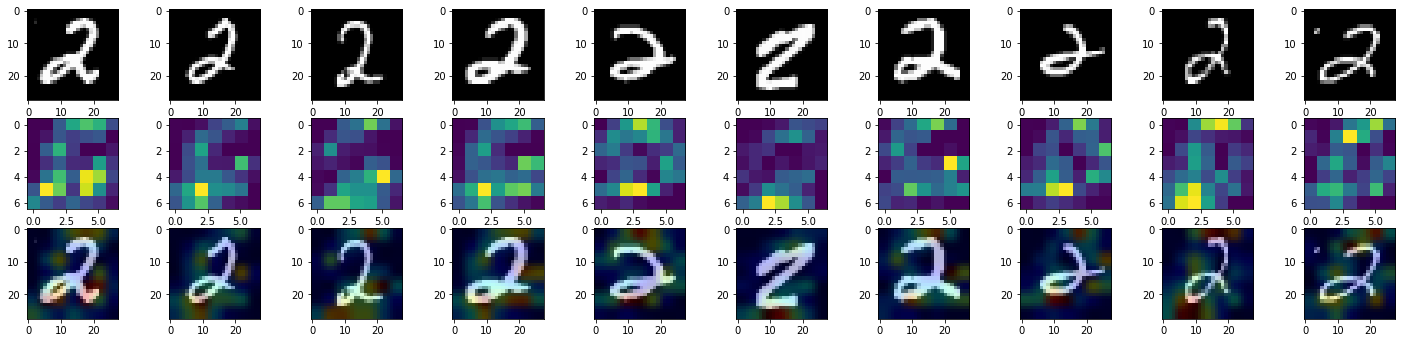


for number : 3



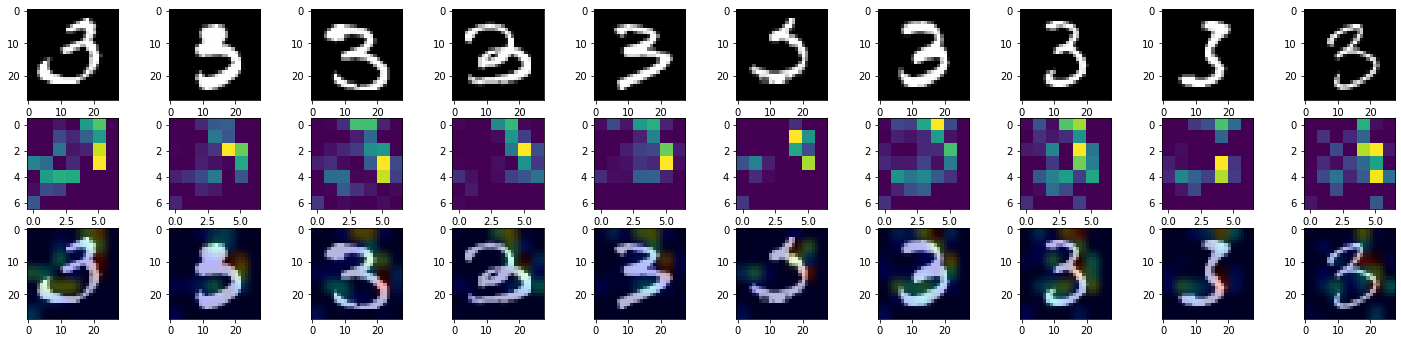


for number : 4



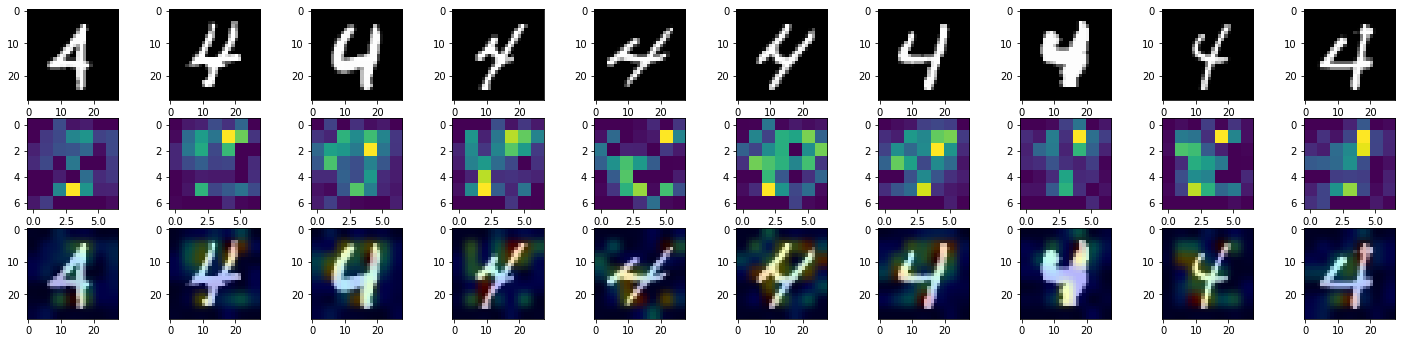


for number : 5



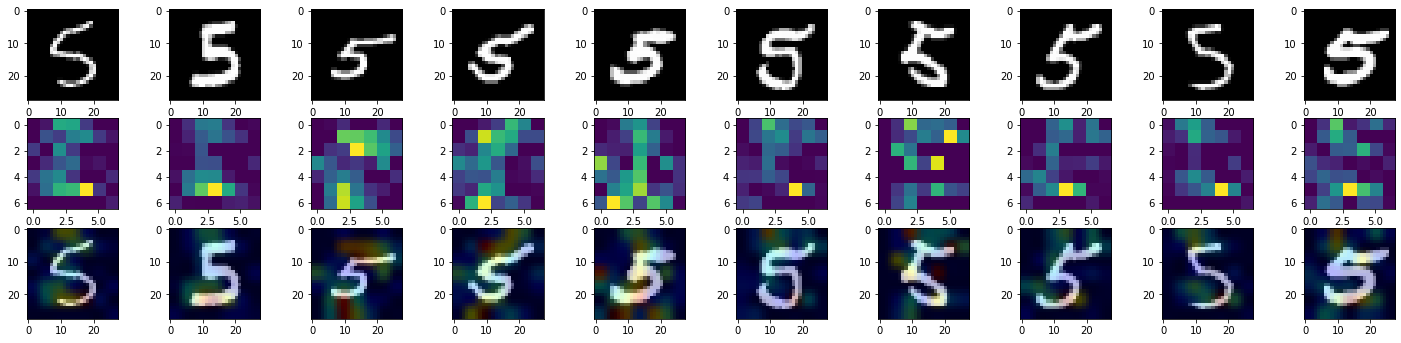


for number : 6



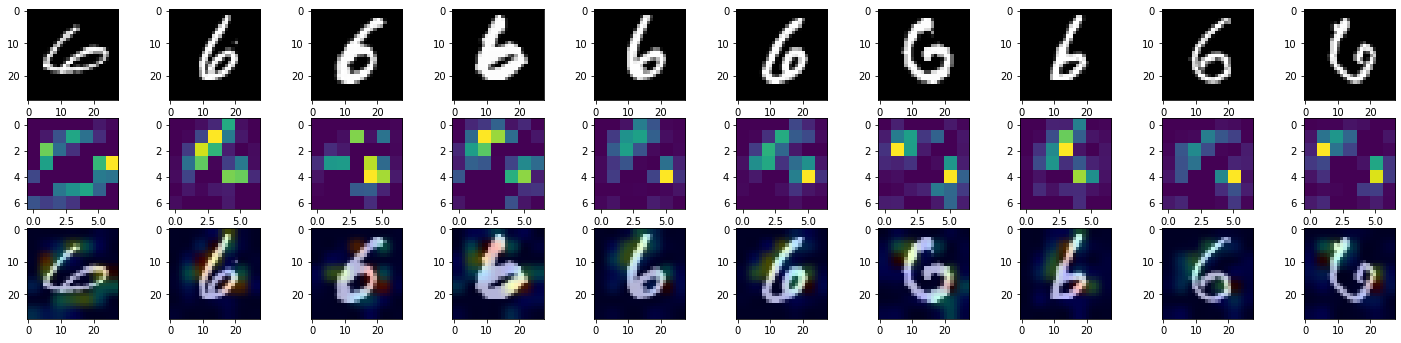


for number : 7



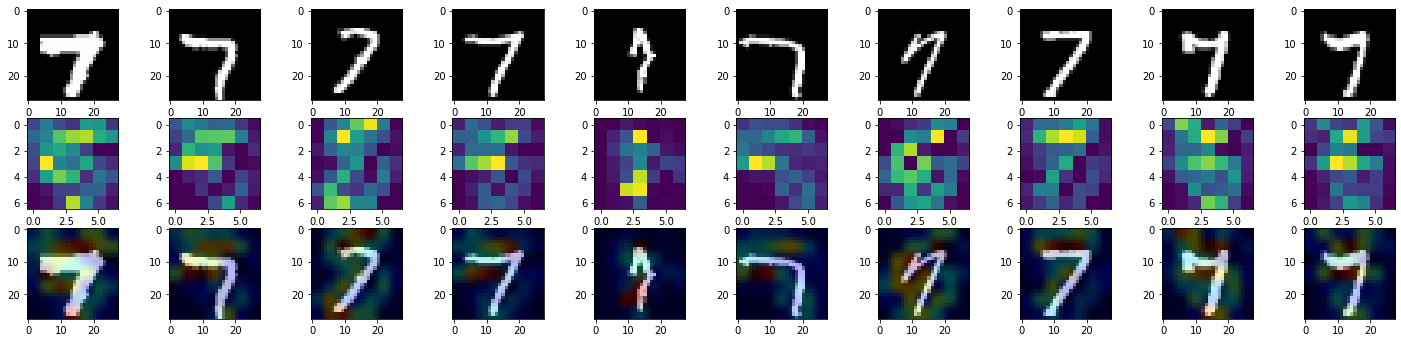


for number : 8



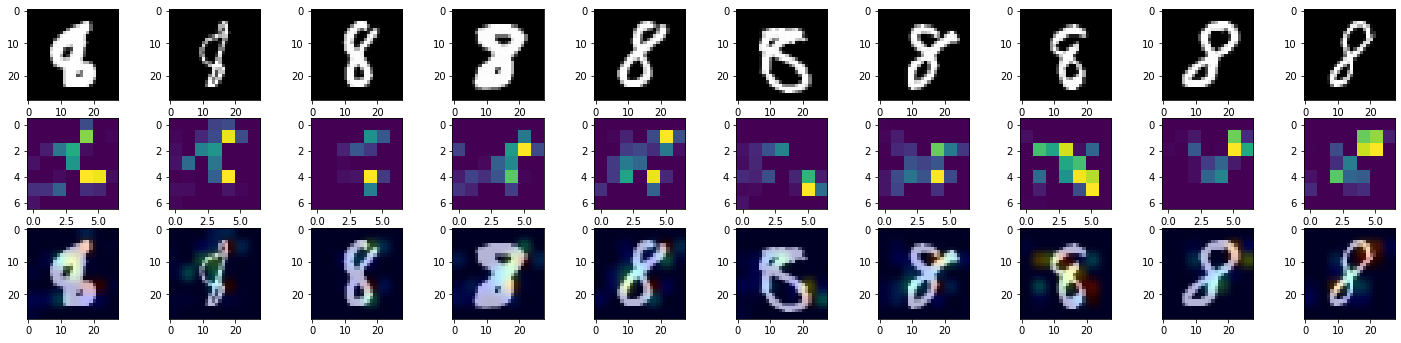


for number : 9



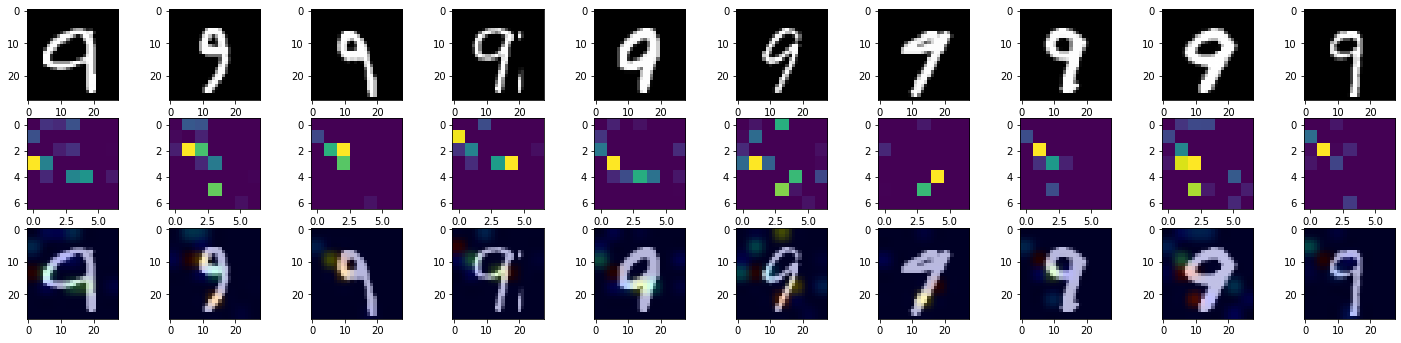

In [ ]:
for i in range(10):
    print('for number : {}'.format(str(i)))
    print()
    img_idxes = img_dict[str(i)]
    plt.figure(figsize=(25, 60))
    display_number_heatmap(img_idxes)
    plt.show()
    print('=' * 40)
    print()


